- HSV 색상공간의 구성

 <img src="../myCode/openCV/lecture_image/hsv.png" width=70%>

- 색상 값 
  - Hue 값은 0-179 범위로 설정
  - 만약 Hue 값을 -로 설정하면 뒤쪽부터 인덱싱됨

<img src="../myCode/openCV/lecture_image/hsv2.png" width=50%>

<table style="border-collapse: collapse; width: 100%; height: 140px;" border="1" data-ke-align="alignLeft" data-ke-style="style12">
<tbody>
<tr style="height: 20px;">
<td style="width: 13.6047%; text-align: center; height: 20px;"><b>명칭</b></td>
<td style="width: 11.5115%; text-align: center; height: 20px;"><b>값의 범위</b></td>
<td style="width: 49.8837%; text-align: center; height: 20px;"><b>참고</b></td>
</tr>
<tr style="height: 40px;">
<td style="width: 13.6047%; height: 40px; text-align: center;"><b>색상(H)</b></td>
<td style="width: 11.5115%; height: 40px; text-align: center;">0 ~ 180</td>
<td style="width: 49.8837%; height: 40px;">원래 0~360범위이지만 OpenCV에서는 1/2 범위이다</td>
</tr>
<tr style="height: 40px;">
<td style="width: 13.6047%; height: 40px; text-align: center;"><b>채도(S)</b></td>
<td style="width: 11.5115%; height: 40px; text-align: center;">0 ~ 255</td>
<td style="width: 49.8837%; height: 40px;">값이 0에 가까우면 하얀색, 255에 가까울수록 H의 색상이 된다.</td>
</tr>
<tr style="height: 40px;">
<td style="width: 13.6047%; height: 40px; text-align: center;"><b>명도(V)</b></td>
<td style="width: 11.5115%; height: 40px; text-align: center;">0 ~ 255</td>
<td style="width: 49.8837%; height: 40px;">값이 0에 가까우면 검은색, 255에 가까울수록 &nbsp;H의 색상이 된다.</td>
</tr>
</tbody>

# 중심점 검출

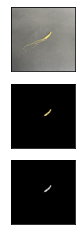

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("../myCode/openCV/image/insam.jpg", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

plt.subplot(3,1,1)
plt.xticks([]); plt.yticks([])
plt.imshow(img)

# 색상, 채도, 명도 순
lower = np.array([20, 100,200])
higher = np.array([30, 255, 255])
mask = cv2.inRange(hsv, lower, higher)
img_hsv = cv2.bitwise_and(img, img, mask=mask)

plt.subplot(3,1,2)
plt.xticks([]); plt.yticks([])
plt.imshow(img_hsv)

plt.subplot(3,1,3)
img_gray = cv2.cvtColor(img_hsv, cv2.COLOR_RGB2GRAY)
plt.xticks([]); plt.yticks([])
plt.imshow(img_gray,cmap='gray')

In [ ]:
#침식
kernel = np.ones((3,3), np.uint8)
# interations : 수행 횟수 (클수록 글씨들이 얇아짐)
img_gray = cv2.erode(img_gray, kernel, iterations=1)

#팽창 (마스크 크게 만들 수 있음, 마스크 노이즈 제거 가능)
kernel = np.ones((3,3), np.uint8)
# deilate : 수행 횟수 (클수록 글씨들이 두꺼워짐)
img_gray = cv2.dilate(img_gray, kernel, iterations=3)
img_gray = cv2.erode(img_gray, kernel, iterations=3)
plt.xticks([]); plt.yticks([])
plt.imshow(img_gray, cmap='gray')

In [ ]:
obj=[]

for x in range(640):
    y = 0
    i = img_gray[x]  
    for j in i:
        if j > 0:
            obj.append([x,y,j])
        y += 1
        
yy = 0
for i in range(len(obj)):
    yy += obj[i][0]
    print(yy)
yy = yy // len(obj)

xx = 0
for i in range(len(obj)):
    xx += obj[i][1]
xx = xx // len(obj)

print(f'({xx},{yy})')

In [ ]:
img_to_point = cv2.circle(img, (xx, yy),5,(255,0,0), -1)
plt.xticks([]); plt.yticks([])
plt.imshow(img_to_point)

# 원검출

- <font color=red>cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, minDis, param1, param2, minRadius, maxRadius)</font>
  - cv2.HOUGH_GRADIENT : 원을 찾는 방법
  - 1 : 원이미지와 허프변환 이미지 간의비율 (1로 설정)
  - minDist : 원 중심들 간의 최소 거리 (0보다 커야 함)
  - param1 : Canny 에지 추출자의 maxVal 값
  - parma2 : 허프변환 카운팅 값 (너무 작으면 원하지 않는 많은 원들이 검출됨)
  - minRadius : 원의 최소 반지름
  - maxRadius : 원의 최대 반지름
  
  
- 원리
  - 이미지에서 에지를 계산
  - 에지에 법선을 긋고 (기울기) 직각인 선을 그림  , 법선:?
    - 설정한 반지름의 범위에 따라 여러 개의 선을 그림
  - 가장 선이 많이 만나는 점에 해당하는 반지름 크기의 원을 찾음  
  
<img src="../myCode/openCV/lecture_image/12_hough03.png" width=30%>  

In [ ]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np

img = cv2.imread('./image/insam3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 원 찾기
circles = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, dp=1,
                           minDist=10, param1=60, param2=95,
                           minRadius=10, maxRadius=100)

# 중심점 좌표와 반지름을 반환
print(circles)

if circles is not None:
    # 좌표는 정수값이므로 실수를 정수로 변환해주는 작업
    circles =np.uint16(np.around(circles))  # aroundd는 반올림해주는 함수

    # 원그리기
    for i in circles[0,:]:
        cv2.circle(img, (i[0], i[1]), i[2], (0,0,255), 4)
                   
    plt.imshow(img)
    plt.axis("off")

# 직선 검출

- <font color=red>cv2.HoughLines(image, rho, theta, threshold)</font>
  - image : single-channel binary image, canny edge를 적용한 이미지
  - rho : r 값의 범위 (0 ~ 1 실수)
  - theta : 𝜃 값의 범위(0 ~ 180 정수)
  - threshold : 만나는 점의 기준, 숫자가 작으면 많은 선이 검출되지만 정확도가 떨어지고 숫자가 크면 정확도가 올라감

In [ ]:
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np

img = cv2.imread('./image/conv2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 에지를 검출하고 에지 이미지에서 선을 검출
dst = cv2.Canny(img_gray, 150, 200)

plt.imshow(dst)

# # 선 검출
# lines = cv2.HoughLines(dst, 1, np.pi/180, 100)  #200최소 200개가 겹쳐야 선으로 인정하겠다?

# # 검출된 선을 그린다
# if lines is not None: #선을 찾았다면
#     # 검색된 선의 수 만큼 반복
#     for i in range(0, len(lines)):
#         # 각도와 길이를 가져온다
#         # [0][0] : 가장 가능성이 높은 각도와 길이를 가져온다.
#         rho = lines[i][0][0] 
#         theta = lines[i][0][1]
        
#         # 시작접과 끝점을 그리기 위해서 x,y축의 삼각비를 계산
#         tx = math.cos(theta)
#         ty = math.sin(theta)
        
#         # 단위 좌표 출력
#         x0 = rho * tx
#         y0 = rho * ty

#         # 기준좌표를 이용해서 선의 시작점과 끝점을 계산
#         d = 1500  #충분시 선을 길게 표시하기 위한 값 (임의 값)
#         x1 = int(x0 + d*(-ty))
#         y1 = int(y0 + d*(tx))
#         x2 = int(x0 - d*(-ty))
#         y2 = int(y0 - d*(tx))
        
#         cv2.line(img, (x1, y1), (x2, y2), (0,0,255), 30, cv2.LINE_AA)
        
# plt.imshow(img)
# plt.axis("off")
        

# 동영상 객체 추적

- <font color=red>ret, win = cv2.CamShift(probImage, window, criteria)</font>
  - probImage: 관심 객체에 대한 히스토그램 역투영 영상 (확률 영상)
  - window: 초기 검색 영역 윈도우 & 결과 영역 반환
  - criteria: 알고리즘 종료 기준 (type, maxCount, epsilon)
   - cv2.TERM_CRITERIA_EPS : 주어진 정확도 (이동 크기)에 도달하면 반복 중단
   - cv2.TERM_CRITERIA_COUNT : 반복 횟수에 도달하면 반복 중단
   - (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1) ➔ 최대 10번 반복하며, 정확도가 1이하이면 (즉, 이동 크기가 1픽셀보다 작으면) 종료.
    
  - ret : 회전된 사각형 정보를 반환 - (x, y, width, height)
  - win : 회전이 안된 사각형 정보를 반환 

In [ ]:
#내꺼
import cv2
cap = cv2.VideoCapture("C:/Users/AI\myCode/openCV/image/car.mp4")

init = 0 # 초기위치 설정 유무

# 종료 조건
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)


while cap.isOpened():  #영상이 열려 있을 때만 반복문 돌아감
    ret, frame = cap.read()
    
    if not ret:
        break
        
    img_draw = frame.copy()
    
    # 만약 초기 시작 위치를 설정하지 않았다면
    if init == 0:
        #텍스트 출력
        cv2.putText(img_draw, "Press set ROI", (10,30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,255), 2, cv2.LINE_AA)
        
    else: 
        frame_hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        
        #투영 이미지 생성
        backproj = cv2.calcBackProject([frame_hsv], [0,1], hist,
                                       [0, 179, 0, 255], 1)
        
        #Camshift를 이용해서 추적
        ret2, rc = cv2.CamShift(backproj, rc, term_crit)
        #추적된 위치 표시
        cv2.rectangle(img_draw, (rc[0], rc[1]), (rc[0]+rc[2], rc[1]+rc[3]), (0, 0, 255), 2)
        
        
    cv2.imshow("Tracking", img_draw)

    key = cv2.waitKey(33)
    
    # 스페이스 바를 누른 경우, 아직 초기 위치를 지정하지 않은 경우
    if key == ord(' ') and init == 0:  
        # 마우스로 추적할 위치를 지정
        x, y, w, h = cv2.selectROI("Tracking", frame, False)

        # 초기 위치를 마우스로 선택했다면
        if w and h :
            rc = (x, y, w, h)


            #선택한 영역을 HSV로 변환
            roi = frame[y:y+h, x:x+w] # 해당이미지만큼 자르기
            roi_hsv = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)

            hist = cv2.calcHist([roi_hsv], [0,1], None,
                                [90, 128], [0, 180, 0, 256])

            # 노말라이저 시전은 해당 값들을 최소 값을 0으로 최대값을 1로해서 정규화 시키는 것 (역투영)
            cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)
            init = 1
    elif key == 49:
        break

cap.release()
cv2.destroyAllWindows()


# 웹캠 연결

In [5]:
# 위젯이용하여 영상 출력 
import ipywidgets as widget
from IPython.display import display
import cv2

img_widget = widget.Image(format=".jpeg", width=480, height=480)
display(img_widget)

cap = cv2.VideoCapture(1)

while True: 
    ret, frame = cap.read()    
    if not ret:
        cap.release #비디오 격리해제 안하면 다시 재생 안됨
        break
        
    try:
        cv2.waitKey(33)
        _, en_img = cv2.imencode(".jpeg", frame)
    except KeyboardInterrupt :
        cap.release()
        break

    img_widget.value = en_img.tobytes() #바이트 단위로 바꿔서 전송해주기 위함


Image(value=b'', format='.jpeg', height='480', width='480')

In [4]:
import cv2

try:
    cap = cv2.VideoCapture(1)
    print("웹캠 연결 성공")
    # 캡쳐한 비디오로부터 프레임이미지를 읽는다.
    while True:
        # ret(성공여부T/F),frame:읽은 이미지 반환 
        ret, frame = cap.read()    

        if not ret: #이미지를 읽지 못했다면
            cap.release() #비디오 객체 메모리에서 해제
            cv2.destroyAllWindows() #창닫기
            break
        
        ############### 이미지 수정 코드 작성 공간 ###############
#         hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
#         lower = np.array([20, 100,200])
#         higher = np.array([30, 255, 255])
#         mask = cv2.inRange(hsv, lower, higher)
#         img_hsv = cv2.bitwise_and(frame, frame, mask=mask)
        img_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
#         #침식
#         kernel = np.ones((3,3), np.uint8)
#         # interations : 수행 횟수 (클수록 글씨들이 얇아짐)
#         img_gray = cv2.erode(img_gray, kernel, iterations=1)
#         #팽창 (마스크 크게 만들 수 있음, 마스크 노이즈 제거 가능)
#         kernel = np.ones((3,3), np.uint8)
#         # deilate : 수행 횟수 (클수록 글씨들이 두꺼워짐)
#         img_gray = cv2.dilate(img_gray, kernel, iterations=3)
#         img_gray = cv2.erode(img_gray, kernel, iterations=3)
        ##########################################################
        
        cv2.imshow("video", img_gray)

        key=cv2.waitKey(66)  # 이 숫자 줄이면 빨리감 33은 1000/33 해서 1초에 30프레임 나오게 하는 것 숫자 줄이면 1초에 더많은 프레임 돌림

        if key ==49 : #숫자1을 누르면
            cap.release() #비디오 객체 메모리에서 해제
            cv2.destroyAllWindows() #창닫기
            break
except:
    print("웹캠 연결 실패")

웹캠 연결 성공
